In [1]:
import os
import pickle

# import pickle file 
with open('../scenario-properties-test_4.pkl', 'rb') as f:
    baseline = pickle.load(f)

/Users/glavezzi/Desktop/pyssem/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
baseline.all_symbolic_vars[::baseline.n_shells]

[S_1, Su_1, Sns_1, N_1, N_750kg_1, N_260kg_1, N_6kg_1]

In [3]:
equations_flattened = [baseline.equations[i, j] for j in range(baseline.equations.cols) for i in range(baseline.equations.rows)]
equations_flattened[::baseline.n_shells]

[-5.23644565378701e-13*pi*N_1*S_1 - 8.57283651937395e-13*pi*N_260kg_1*S_1 - 5.1068448421633e-13*pi*N_6kg_1*S_1 - 1.84306835694121e-12*pi*N_750kg_1*S_1 - 3.68613671388242e-17*pi*S_1**2 - 5.1068448421633e-13*pi*S_1*Sns_1 - 8.57283651937395e-18*pi*S_1*Su_1 - 0.125*S_1,
 -8.52245797227933e-14*pi*N_1*Su_1 - 2.44229421707391e-13*pi*N_260kg_1*Su_1 - 8.00445834373181e-14*pi*N_6kg_1*Su_1 - 8.57283651937395e-13*pi*N_750kg_1*Su_1 - 8.57283651937395e-18*pi*S_1*Su_1 - 8.00445834373181e-14*pi*Sns_1*Su_1 - 4.88458843414782e-18*pi*Su_1**2 - 0.125*Su_1,
 -6.50575719102523e-10*pi*N_1*Sns_1 - 8.00445834373181e-9*pi*N_260kg_1*Sns_1 - 5.13333517688403e-10*pi*N_6kg_1*Sns_1 - 5.1068448421633e-8*pi*N_750kg_1*Sns_1 - 5.1068448421633e-13*pi*S_1*Sns_1 - 1.02666703537681e-9*pi*Sns_1**2 - 8.00445834373181e-14*pi*Sns_1*Su_1 - 0.333333333333333*Sns_1,
 -1.60811492433252e-9*pi*N_1**2 - 8.52245797227933e-9*pi*N_1*N_260kg_1 - 6.50575719102523e-10*pi*N_1*N_6kg_1 - 5.23644565378701e-8*pi*N_1*N_750kg_1 - 5.23644565378701e

In [6]:
# baseline.all_symbolic_vars[:6*baseline.n_shells]
num_species = len(baseline.species_names)
baseline.all_symbolic_vars[num_species*baseline.n_shells:]
s_species_indices = [i for i, species_name in enumerate(baseline.species_names) if species_name.startswith('S')]
s_species_indices

[0, 1, 2, 3, 4, 5]

In [7]:
baseline.all_symbolic_vars[14*baseline.n_shells]

B_1

In [8]:
len(equations_flattened)

210

In [10]:
15*14

210

In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# import pickle file 
with open('../scenario-properties-test.pkl', 'rb') as f:
    baseline = pickle.load(f)

In [3]:
# Equations
baseline.equations

# x0 initial population
baseline.x0

# baseline.
baseline.all_symbolic_vars

# solver
equations_flattened = [baseline.equations[i, j] for j in range(baseline.equations.cols) for i in range(baseline.equations.rows)]

full_lambda = sp.Matrix(sp.symbols([f'lambda_{i+1}' for i in range(baseline.n_shells)]))
full_lambda_flattened = [full_lambda[i, j] for j in range(full_lambda.cols) for i in range(full_lambda.rows)]

for i1 in range(baseline.n_shells):
    equations_flattened[i1] = equations_flattened[i1]+full_lambda_flattened[i1]

baseline.all_symbolic_vars = baseline.all_symbolic_vars + full_lambda_flattened

equations = [sp.lambdify(baseline.all_symbolic_vars, eq, 'numpy') for eq in equations_flattened]

In [7]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import NonlinearConstraint
from scipy.integrate import solve_ivp

def PrfAll(x, baseline):
  """
  Python version of the PrfAll function.

  Args:
    x: Input array, where the first N_shell elements represent S_all.
    baseline: Dictionary containing data, including 'N_shell'.

  Returns:
    f: Objective function.
  """

  N_shell = baseline.n_shells
  S_all = x[:N_shell]  # Extract S_all from x

  # HIGH CAPACITY
  # f = -np.sum(np.log(S_all)**1)
  f = -np.sum(np.log(S_all)**2) 
  # f = -np.sum(np.log(S_all)**3) 
  # f = 1/np.sum(S_all) 

  # NOT HIGH CAPACITY
  # f = - np.sum(np.log(S_all[5:8])) # shells at 500-600 km (Python index starts at 0)
  # f = - np.sum(S_all[6]) # shell at 550 km (Python index starts at 0)

  return f

def PrCeqAll(x, fun_ceq):
    """
    Args:
      x: The optimization variables.
      baseline: Your baseline object containing symbolic variables.

    Returns:
      An array containing the results of all equality constraint function evaluations.
    """

    c_eq = np.array(fun_ceq(x)) #.flatten()

    return c_eq

def PrIneqAll(x,baseline,failure_rate_U):
    """
    Args:
      x: The optimization variables.
      baseline: Your baseline object containing symbolic variables.

    Returns:
      An array containing the results of all inequality constraint function evaluations.
    """

    N_shell = baseline.n_shells
    S_all = x[:N_shell]
    lambda_all = x[3*N_shell:4*N_shell]
    deltat = 8
    y_fail_u = []
    for i1 in range(N_shell):
        y_fail_u.append( -(lambda_all[i1] * deltat * (1 - failure_rate_U) - S_all[i1]) ) 
    c_ineq = y_fail_u

    return c_ineq

## Initial guess
N_shell = baseline.n_shells
print(baseline.species_names)
S_0 = np.ones(len(baseline.all_symbolic_vars[0:N_shell]))
N_0 = np.ones(len(baseline.all_symbolic_vars[N_shell:2*N_shell]))
D_0 = np.ones(len(baseline.all_symbolic_vars[2*N_shell:3*N_shell]))
lam_0 = np.ones(len(baseline.all_symbolic_vars[3*N_shell:4*N_shell]))
x0 = np.concatenate([S_0, N_0, D_0, lam_0]) * 0

## Bounds
lb = np.concatenate([np.ones(len(S_0)) * 1,
                     np.ones(len(N_0)) * 1, 
                     np.ones(len(D_0)) * 1, 
                     np.ones(len(lam_0)) * 1
                     ]) 
ub = np.inf

## Farilure rate, % = fail_rate / 100
failure_rate_U = 100
failure_rate_U = failure_rate_U/100

## Objective function
objective = PrfAll

## Constraints for SLSQP
f3 = equations_flattened
var_c = baseline.all_symbolic_vars
fun_ceq = sp.lambdify((var_c,), f3, 'numpy')
con1 = {'type': 'eq', 'fun': lambda x: PrCeqAll(x, fun_ceq)}
con2 = {'type': 'ineq', 'fun': lambda x: PrIneqAll(x,baseline,failure_rate_U)}
nonlcon = [con1, con2]

## Options for SLSQP
options = {
    'disp': True,   
    'maxiter': 5e5,
    'ftol': 1e-6,     
    'eps': 1e-18,
    # 'finite_diff_rel_step': 1e-12,     
}

## Perform the optimization
result = minimize(objective, x0, args=(baseline), method='SLSQP', 
                  jac='cs', hess=None, hessp=None, 
                  bounds = Bounds(lb=lb, ub=ub, keep_feasible=False), 
                  constraints = nonlcon,
                  options = options)

## Print the results
print("Optimal found at:", result.x)
print("Function value at optimal:", -result.fun)
print("Equality constraints:", np.array([sp.lambdify(baseline.all_symbolic_vars, eq, 'numpy')(*result.x) for eq in equations_flattened]))
result

['S', 'N', 'D']
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1455.8371155580462
            Iterations: 1236
            Function evaluations: 71714
            Gradient evaluations: 1236
Optimal found at: [1.00974227e+07 2.55259851e+06 8.29427214e+05 3.25513793e+05
 1.24629865e+05 5.10909795e+04 2.09195172e+04 8.43029508e+03
 3.01726684e+03 1.09000629e+03 3.37526653e+02 1.22891559e+02
 4.56287228e+01 2.59689300e+01 9.14684853e+05 2.20880953e+05
 7.08781250e+04 2.58992696e+04 1.04492524e+04 4.34713556e+03
 1.90608366e+03 8.58567584e+02 4.05055344e+02 1.87778445e+02
 9.33240366e+01 4.12398015e+01 1.79312710e+01 4.27751266e+00
 1.04206702e+06 2.51935465e+05 8.11089824e+04 2.98789002e+04
 1.22799611e+04 5.31092511e+03 2.49665174e+03 1.25103823e+03
 6.72828306e+02 3.61686820e+02 2.03204182e+02 1.09046488e+02
 6.04638998e+01 2.65023413e+01 2.39123795e+06 3.88313426e+05
 1.10838197e+05 4.17361558e+04 1.57357000e+04 6.41302701e+03
 2.61967324e+03 

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1455.8371155580462
       x: [ 1.010e+07  2.553e+06 ...  5.704e+00  3.246e+00]
     nit: 1236
     jac: [-3.194e-06 -1.156e-05 ... -0.000e+00 -0.000e+00]
    nfev: 71714
    njev: 1236

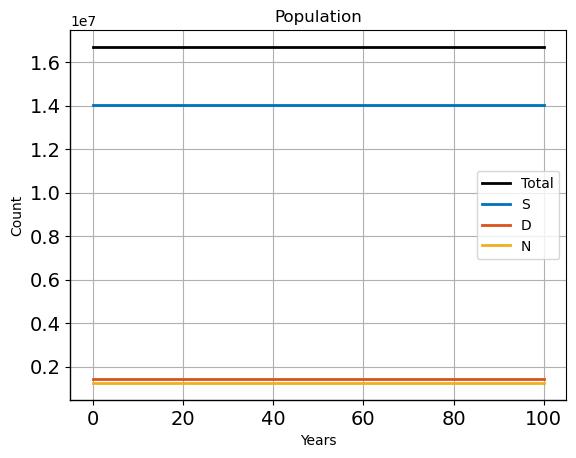

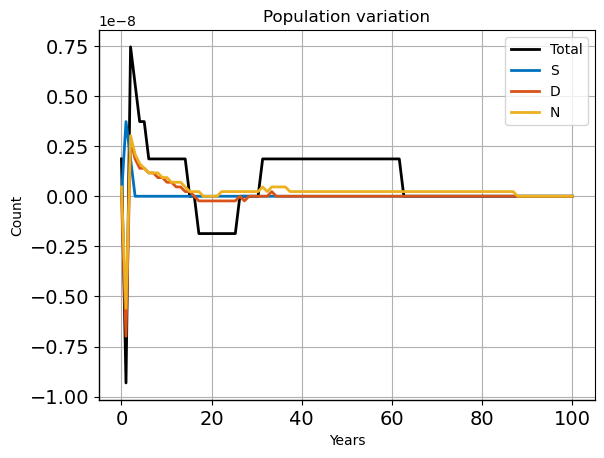

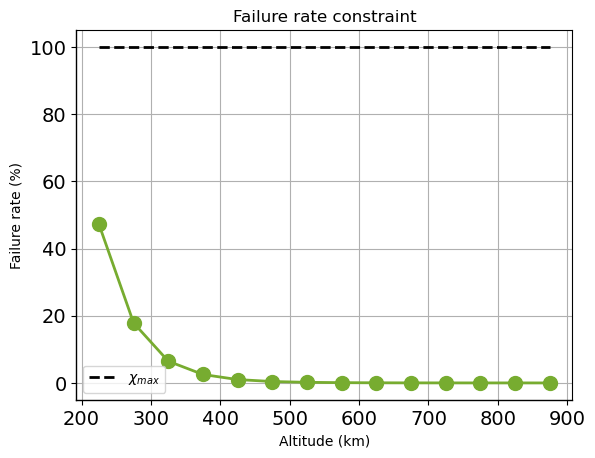

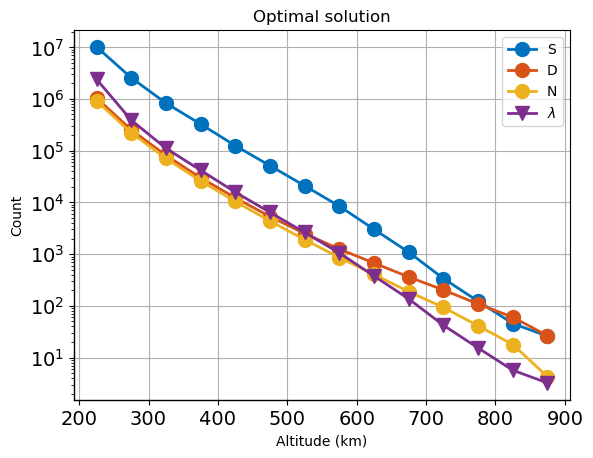

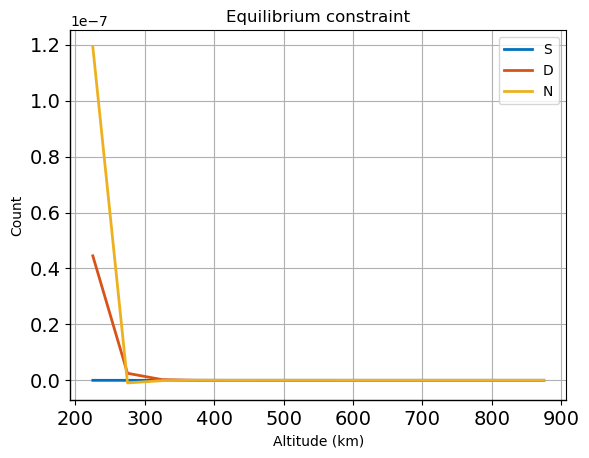

In [5]:
N_shell = baseline.n_shells
R02 = baseline.R0_km
xopt = result.x

S_opt = xopt[0:N_shell]
N_opt = xopt[N_shell:2*N_shell] 
D_opt = xopt[2*N_shell:3*N_shell]
lam_opt = xopt[3*N_shell:4*N_shell]
# lam_opt = xopt[2*N_shell:3*N_shell]

c_eq = np.array([sp.lambdify(baseline.all_symbolic_vars, eq, 'numpy')(*xopt) for eq in equations_flattened])
S_eq = c_eq[0:N_shell]
N_eq = c_eq[N_shell:2*N_shell]
D_eq = c_eq[2*N_shell:3*N_shell]

var = baseline.all_symbolic_vars[:3*N_shell]
lam = baseline.all_symbolic_vars[3*N_shell:]
# var = baseline.all_symbolic_vars[:2*N_shell]
# lam = baseline.all_symbolic_vars[2*N_shell:]
f3 = equations_flattened
fun3 = sp.lambdify((var, lam), f3, 'numpy')

def func(t, x, fun3, lam_opt):
    """ODE system function for solve_ivp."""
    return np.array(fun3(x, np.array(lam_opt))).flatten()

tf_ss = 100
tspan1 = np.linspace(0, tf_ss, 100)
sol = solve_ivp(func, (0, tf_ss), xopt[:3*N_shell], 
                method=baseline.integrator,
                t_eval=tspan1, 
                args=(fun3,lam_opt),
                rtol=1e-8, atol=1e-8)

t_prop = sol.t
x_prop = sol.y

S_prop = x_prop[0:N_shell]
N_prop = x_prop[N_shell:2*N_shell]
D_prop = x_prop[2*N_shell:3*N_shell]
N_tot = S_prop + D_prop + N_prop
# N_tot = S_prop + N_prop
N_tot_sum = sum(N_tot,2)
S_sum = sum(S_prop,2)
D_sum = sum(D_prop,2)
N_sum = sum(N_prop,2)

# Plots
colors = [
    [0, 0, 0],
    [0, 0.4470, 0.7410],
    [0.8500, 0.3250, 0.0980],
    [0.9290, 0.6940, 0.1250],
    [0.4940, 0.1840, 0.5560],
    [0.4660, 0.6740, 0.1880],
]
sel_LineWidth = 2
sel_MarkerWidth = 10
sel_LineWidthAxis = 1
sel_FontSize = 14
deltat = 8

plt.figure(facecolor='w')
plt.grid(True)
plt.plot(t_prop, N_tot_sum, color=colors[0], linewidth=sel_LineWidth)
plt.plot(t_prop, S_sum, color=colors[1], linewidth=sel_LineWidth)
plt.plot(t_prop, D_sum, color=colors[2], linewidth=sel_LineWidth)
plt.plot(t_prop, N_sum, color=colors[3], linewidth=sel_LineWidth)
plt.title("Population")
plt.xlabel("Years")
plt.ylabel("Count")
plt.legend(["Total", "S", "D", "N"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("so_variation_no_fail.pdf", dpi=300)  

plt.figure(facecolor='w')
plt.grid(True)
plt.plot(t_prop, N_tot_sum[-1] - N_tot_sum, color=colors[0], linewidth=sel_LineWidth)
plt.plot(t_prop, S_sum[-1] - S_sum, color=colors[1], linewidth=sel_LineWidth)
plt.plot(t_prop, D_sum[-1] - D_sum, color=colors[2], linewidth=sel_LineWidth)
plt.plot(t_prop, N_sum[-1] - N_sum, color=colors[3], linewidth=sel_LineWidth)
plt.title("Population variation")
plt.xlabel("Years")
plt.ylabel("Count")
plt.legend(["Total", "S", "D", "N"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("so_variation_no_fail.pdf", dpi=300)  

plt.figure(facecolor='w')
plt.grid(True)
plt.plot(R02[1:] - 25, 100 * failure_rate_U * np.ones_like(R02[1:]), '--', color=colors[0], linewidth=sel_LineWidth)
plt.plot(R02[1:] - 25, 100 * (deltat * lam_opt - S_opt) / (deltat * lam_opt), '-o', color=colors[5], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.title("Failure rate constraint")
plt.xlabel("Altitude (km)")
plt.ylabel("Failure rate (%)")
plt.legend(["$\chi_{max}$"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("fail_rate_no_fail.pdf", dpi=300)  

plt.figure(facecolor='w')
plt.semilogy(R02[1:] - 25, S_opt, '-o', color=colors[1], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.grid(True)
plt.semilogy(R02[1:] - 25, D_opt, '-o', color=colors[2], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.semilogy(R02[1:] - 25, N_opt, '-o', color=colors[3], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.semilogy(R02[1:] - 25, lam_opt, '-v', color=colors[4], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.title("Optimal solution")
plt.xlabel("Altitude (km)")
plt.ylabel("Count")
plt.legend(["S", "D", "N", "$\lambda$"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("max_capacity_no_fail.pdf", dpi=300)  

plt.figure(facecolor='w')
plt.grid(True)
plt.plot(R02[1:] - 25, S_eq, color=colors[1], linewidth=sel_LineWidth)
plt.plot(R02[1:] - 25, D_eq, color=colors[2], linewidth=sel_LineWidth)
plt.plot(R02[1:] - 25, N_eq, color=colors[3], linewidth=sel_LineWidth)
plt.title("Equilibrium constraint")
plt.xlabel("Altitude (km)")
plt.ylabel("Count")
plt.legend(["S", "D", "N"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("equil_constr_no_fail.pdf", dpi=300)  
